# Case Study: Real-Time Credit Card Fraud Detection

## Background: real-time feature engineering with DBSP

**Feature engineering** is the process of transforming raw data into a set of features that can be used to improve the predictive accuracy of an ML model.  Features are often expressed as SQL queries that filter, transform, aggregate, and join raw data.  These queries are evaluated by an RDBMS, e.g., Postgres, and the results are fed to the ML model during training and inference stages.

**Real-time feature engineering** arises in applications where data arrives continuously and requires immediate analysis, such as fraud detection and anomaly detection.  The main challenge in this process is extracting features from constantly changing data.  Although simple cases can be handled by streaming analytics platforms like Flink, they fall short when it comes to complex SQL queries that feature engineers commonly use (we will see examples of such queries in this case study!).  A common workaround is to precompute features through periodic batch jobs in an RDBMS such as BigQuery and inject the precomputed features into the real-time data stream.  This approach allows arbitrary feauture queries but sacrifices **feature freshness**, resulting in poor prediction accuracy in many real-time ML applications since precomputed features do not reflect the latest input data.

**Feldera aims to provide the benefits of both worlds** by evaluating complex feature queries directly on streaming data, eliminating the need for batch jobs and delivering perfect feature freshness.

## About this case study

Our goal in this case study is two-fold:

1. To illustrate how ML engineers can invoke Feldera from a Jupyter notebook to evaluate feature extraction queries on streaming data during model training, testing, and inference.
1. To empirically prove that Feldera enhances prediction accuracy in real-time ML.  Specifically, we demonstrate that **both complex queries and data freshness are critical for achieving high accuracy in real-time ML applications**.

This case study is based on the credit card fraud detection solution published by the Google Cloud blog:
https://cloud.google.com/blog/products/data-analytics/how-to-build-a-fraud-detection-solution

In [9]:
import os
import tarfile
import gdown
from os import path
import pandas as pd
from datetime import datetime
import geopy
import geopy.distance
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve
from collections import Counter
from sklearn.utils import shuffle
import warnings
import urllib.request
import json
import tensorflow as tf


warnings.filterwarnings('ignore')

train_url = "https://raw.githubusercontent.com/feldera/ci_datasets/0eed3caac45415f6cd531dc5cb2e7f531d09a823/train_ci.csv"
test_url = "https://raw.githubusercontent.com/feldera/ci_datasets/0eed3caac45415f6cd531dc5cb2e7f531d09a823/test_ci.csv"
simulation_url = "https://raw.githubusercontent.com/feldera/ci_datasets/0eed3caac45415f6cd531dc5cb2e7f531d09a823/simulation_ci.csv"
demographics_url = "https://github.com/feldera/ci_datasets/raw/e06f92fbd74f11d96ceb8b19c7692d05c7aca6d0/demographics.csv"

train_outpath        = path.abspath("fraud_data/train_output.csv")
test_outpath         = path.abspath("fraud_data/test_output.csv")
simulation_outpath   = path.abspath("fraud_data/simulation_output.csv")

## Prepare a feature extraction query

In [10]:
import os
import time
import requests

# API URL
api_url = "http://localhost:8080"

# Program
program_name = "demo-fraud-detection-notebook-program"
program_sql = """
CREATE TABLE demographics (
    cc_num FLOAT64 NOT NULL,
    first STRING,
    gender STRING,
    street STRING,
    city STRING,
    state STRING,
    zip INTEGER,
    lat FLOAT64 NOT NULL,
    long FLOAT64 NOT NULL,
    city_pop INTEGER,
    job STRING,
    dob STRING
    --dob DATE
);

CREATE TABLE transactions (
    trans_date_trans_time TIMESTAMP NOT NULL,
    cc_num FLOAT64 NOT NULL,
    merchant STRING,
    category STRING,
    amt FLOAT64,
    trans_num STRING,
    unix_time INTEGER NOT NULL,
    merch_lat FLOAT64 NOT NULL,
    merch_long FLOAT64 NOT NULL,
    is_fraud INTEGER
);

CREATE VIEW features as
    SELECT
        DAYOFWEEK(trans_date_trans_time) AS d,
        -- TIMESTAMPDIFF(YEAR, trans_date_trans_time, CAST(dob as TIMESTAMP)) AS age,
        "ST_DISTANCE"("ST_POINT"(long,lat), "ST_POINT"(merch_long,merch_lat)) AS distance,
        -- TIMESTAMPDIFF(MINUTE, trans_date_trans_time, last_txn_date) AS trans_diff,
        AVG(amt) OVER(
            PARTITION BY   CAST(cc_num AS NUMERIC)
            ORDER BY unix_time
            -- 1 week is 604800  seconds
            RANGE BETWEEN 604800  PRECEDING AND 1 PRECEDING) AS
        avg_spend_pw,
        AVG(amt) OVER(
            PARTITION BY  CAST(cc_num AS NUMERIC)
            ORDER BY unix_time
            -- 1 month(30 days) is 2592000 seconds
            RANGE BETWEEN 2592000 PRECEDING AND 1 PRECEDING) AS
        avg_spend_pm,
        IFNULL(AVG(amt) OVER(
            PARTITION BY CAST(cc_num AS NUMERIC), EXTRACT(DAY FROM trans_date_trans_time)
            ORDER BY unix_time
            RANGE BETWEEN 7776000 PRECEDING AND 1 PRECEDING), 0) AS
        avg_spend_p3m_over_d,
        COUNT(*) OVER(
            PARTITION BY  CAST(cc_num AS NUMERIC)
            ORDER BY unix_time
            -- 1 day is 86400  seconds
            RANGE BETWEEN 86400  PRECEDING AND 1 PRECEDING ) AS
        trans_freq_24,
        category,
        amt,
        state,
        job,
        unix_time,
        city_pop,
        merchant,
        is_fraud
    FROM (
        SELECT t1.*, t2.*
               -- , LAG(trans_date_trans_time, 1) OVER (PARTITION BY t1.cc_num  ORDER BY trans_date_trans_time ASC) AS last_txn_date
        FROM  transactions AS t1
        JOIN  demographics AS t2
        ON t1.cc_num = t2.cc_num);"""

# Create program
response = requests.put(f"{api_url}/v0/programs/{program_name}", json={
    "description": "",
    "code": program_sql
})
response.raise_for_status()
program_version = response.json()["version"]

# Compile program
print(f"Compiling program {program_name} (version: {program_version})...")
requests.post(f"{api_url}/v0/programs/{program_name}/compile", json={"version": program_version}).raise_for_status()
while True:
    status = requests.get(f"{api_url}/v0/programs/{program_name}").json()["status"]
    print(f"Program status: {status}")
    if status == "Success":
        break
    elif status != "Pending" and status != "CompilingRust" and status != "CompilingSql":
        raise RuntimeError(f"Failed program compilation with status {status}")
    time.sleep(5)
print("done")

Compiling program demo-fraud-detection-notebook-program (version: 1)...
Program status: Success
done


In [28]:
import time
import threading

def wait_for_pipeline(pipeline_name: str):
    # Wait till the pipeline is completed
    while not requests.get(f"{api_url}/v0/pipelines/{pipeline_name}/stats") \
            .json()["global_metrics"]["pipeline_complete"]:
        time.sleep(1)
    
    requests.post(f"{api_url}/v0/pipelines/{pipeline_name}/shutdown").raise_for_status()


def run_query(transaction_url: str, output_file: str):

    # Connectors
    connectors = []
    for (connector_name, stream, url, is_input) in [
        ("demographics", 'DEMOGRAPHICS', demographics_url, True),
        ("transactions", 'TRANSACTIONS', transaction_url, True),
    ]:
        requests.put(f"{api_url}/v0/connectors/{connector_name}", json={
            "description": "",
            "config": {
               "format": { "name": "csv", "config": {} },
               "transport": { "name": "url", "config": { "path": url, } }
            }
        })
        connectors.append({ "connector_name": connector_name, "is_input": is_input, "name": connector_name, "relation_name": stream })
    
    # Create pipeline
    pipeline_name = "demo-fraud-detection-notebook-pipeline"
    requests.put(f"{api_url}/v0/pipelines/{pipeline_name}", json={
        "description": "",
        "config": {"workers": 6},
        "program_name": program_name,
        "connectors": connectors,
    }).raise_for_status()
    
    # Start pipeline in paused state, so we don't miss any outputs
    print("(Re)starting pipeline...")
    requests.post(f"{api_url}/v0/pipelines/{pipeline_name}/shutdown").raise_for_status()
    while requests.get(f"{api_url}/v0/pipelines/{pipeline_name}").json()["state"]["current_status"] != "Shutdown":
        time.sleep(1)
    requests.post(f"{api_url}/v0/pipelines/{pipeline_name}/pause").raise_for_status()
    while requests.get(f"{api_url}/v0/pipelines/{pipeline_name}").json()["state"]["current_status"] != "Paused":
        time.sleep(1)
        
    print("Pipeline (re)started")

    # Start listening for the output stream
    features = requests.post(f"{api_url}/v0/pipelines/{pipeline_name}/egress/features?format=csv", stream = True)   

    # Run the pipeline
    requests.post(f"{api_url}/v0/pipelines/{pipeline_name}/start").raise_for_status()
    while requests.get(f"{api_url}/v0/pipelines/{pipeline_name}").json()["state"]["current_status"] != "Running":
        time.sleep(1)
    
    # Wait for the pipeline to complete. The thread will shutdown the pipeline when it's done,
    # allowing the iteration below to terminate.
    thread = threading.Thread(target=wait_for_pipeline(pipeline_name))
    thread.start()
        
    print(f"writing features to {output_file}")
    with open(output_file, "w") as feature_file:
        for line in features.iter_lines():
            if line:
                #print(line)
                #print(json.loads(line).get("text_data"))
                data = json.loads(line).get("text_data")
                if data is not None:
                    feature_file.write(data + '\n')

## Compute features on training and testing datasets

In [29]:
#run_query(train_url, train_outpath)
#print("Training pipeline finished")
run_query(test_url, test_outpath)
print("Test pipeline finished")

(Re)starting pipeline...
Pipeline (re)started
writing features to /Users/gerdzellweger/workspace/dbsp/demo/demo_notebooks/fraud_data/test_output.csv


JSONDecodeError: Unterminated string starting at: line 1 column 34 (char 33)

## Train XGBoost model

In [10]:
def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        global pr, rec, f1
        pr = tp/(tp+fp)
        rec=  tp/(tp+fn)
        f1 = (2*(pr*rec)/(pr+rec))
        print('Precision =     {:.3f}'.format(pr))
        print('Recall (TPR) =  {:.3f}'.format(rec))
        #print('Fallout (FPR) = {:.3f}'.format(fp/(fp+tn)))
        print('F1 = {:.3f}'.format(f1))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

max_depth = 12
n_estimators = 100

traindata     = pd.read_csv(train_outpath, float_precision='round_trip')  
train_dataset = shuffle(traindata)

test_dataset     = pd.read_csv(test_outpath, float_precision='round_trip')  

nb_cols = len(train_dataset.columns.tolist())
    
X_train = train_dataset.iloc[:, 0:nb_cols - 2].values
y_train = train_dataset.iloc[:, nb_cols-2].values.astype(int)        

X_test = test_dataset.iloc[:, 0:nb_cols - 2].values
y_test = test_dataset.iloc[:, nb_cols-2].values.astype(int)    


model = XGBClassifier(max_depth = max_depth,  n_estimators = n_estimators, objective = 'binary:logistic')#, scale_pos_weight= estimate) 
setattr(model, 'verbosity', 0)


model.fit(X_train, y_train)

# evaluate train data
y_pred = model.predict(X_train)
predictions = [round(value) for value in y_pred]
cm = confusion_matrix(y_train, predictions)
show_data(cm, print_res = 1)

# evaluate for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
cm = confusion_matrix(y_test, predictions)
show_data(cm, print_res = 1)

accuracy = accuracy_score(y_test, predictions)
print("XGBoost Accuracy: %.2f%%" % (accuracy * 100.0))



Precision =     1.000
Recall (TPR) =  1.000
F1 = 1.000
Precision =     0.942
Recall (TPR) =  0.920
F1 = 0.931
XGBoost Accuracy: 99.79%


## Inference

In [11]:
run_query(simulation_url, simulation_outpath)

(Re)starting pipeline...
Pipeline (re)started
writing features to c:\Users\rivud\OneDrive\Desktop\MODEL\fraud_data\simulation_output.csv


In [12]:
try:
    chunksize = 1024*10
    print(f"reading data from {simulation_outpath}")
    simulation = pd.read_csv(simulation_outpath, iterator=True, chunksize=chunksize)
    for simulation_batch in simulation:
        nb_cols = len(simulation_batch.columns.tolist())        
        X_simulation = simulation_batch.iloc[:, 0:nb_cols - 2].values
        y_simulation = simulation_batch.iloc[:, nb_cols-2].values.astype(int)     
        
        y_pred = model.predict(X_simulation)    
        predictions = [round(value) for value in y_pred]
        cm = confusion_matrix(y_simulation, predictions)
        show_data(cm, print_res = 1)    
        accuracy = accuracy_score(y_simulation, predictions)
        print("XGBoost Accuracy: %.2f%%" % (accuracy * 100.0))
     
except Exception as err:
    print(f"Error: cannot read from the specified source {err}")

reading data from c:\Users\rivud\OneDrive\Desktop\MODEL\fraud_data\simulation_output.csv
Precision =     0.700
Recall (TPR) =  0.933
F1 = 0.800
XGBoost Accuracy: 99.73%
Precision =     0.945
Recall (TPR) =  0.979
F1 = 0.962
XGBoost Accuracy: 99.89%
Precision =     0.991
Recall (TPR) =  0.888
F1 = 0.937
XGBoost Accuracy: 99.72%
Precision =     0.985
Recall (TPR) =  0.873
F1 = 0.926
XGBoost Accuracy: 99.79%
Precision =     0.992
Recall (TPR) =  0.961
F1 = 0.976
XGBoost Accuracy: 99.93%


In [13]:
log_dir = 'logs/xgboost_fraud_detection1'
os.makedirs('logs/xgboost_fraud_detection1', exist_ok=True)
print(f"Log directory: {log_dir}") 

Log directory: logs/xgboost_fraud_detection1


In [14]:
# train_summary_writer = tf.summary.create_file_writer(os.path.join(log_dir, 'train'))
# test_summary_writer = tf.summary.create_file_writer(os.path.join(log_dir, 'test'))
# simulation_summary_writer = tf.summary.create_file_writer(os.path.join(log_dir, 'simulation'))

In [14]:
summary_writer = tf.summary.create_file_writer(log_dir)

In [15]:
step = 0
with summary_writer.as_default():
    tf.summary.scalar('accuracy', accuracy, step= step)
    tf.summary.scalar('precision', pr, step= step)
    tf.summary.scalar('recall', rec, step= step)
    tf.summary.scalar('f1_score', f1, step= step)
# step += 1


In [16]:
%load_ext tensorboard
%tensorboard --logdir logs/xgboost_fraud_detection1

Launching TensorBoard...

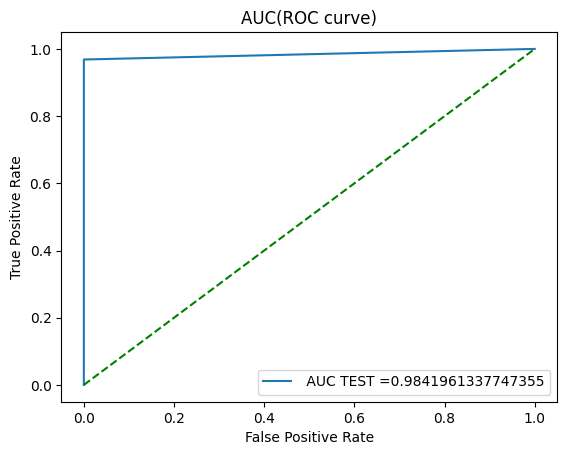

In [15]:
import matplotlib.pyplot as plt
#Printing AUC
from sklearn.metrics import roc_curve, auc
y_PredTest= model.predict_proba(X_simulation)

fp, tp,_ = roc_curve(y_simulation, y_pred)


plt.plot(fp, tp, label=" AUC TEST ="+str(auc(fp, tp)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.show()

In [17]:

importance = model.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00135
Feature: 1, Score: 0.00152
Feature: 2, Score: 0.01373
Feature: 3, Score: 0.01571
Feature: 4, Score: 0.03326
Feature: 5, Score: 0.01085
Feature: 6, Score: 0.90136
Feature: 7, Score: 0.00721
Feature: 8, Score: 0.00227
Feature: 9, Score: 0.00259
Feature: 10, Score: 0.00570
Feature: 11, Score: 0.00256
Feature: 12, Score: 0.00190


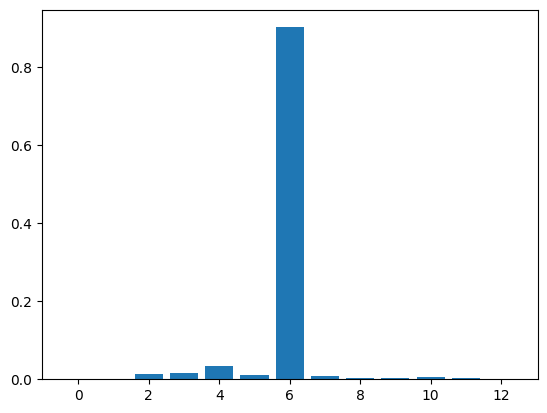

In [19]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()